In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline
    
if 0:
    # the following names should be changed for each use
    # specify the location and name of the DEM
    fdir = "D:\\crs\\proj\\2015_Sandwich\\2017-09-18_U039_SandwichTNB\\products\\"
    fname = ("2017-09-18_U039_SandwichTNB_v3_DEM_10cm.tif")
    # specify the name of the transect file (assumed to be in same directory)
    tfname = '2017-09-18_trans.txt'
    # text for plot titles
    ttext = "Sandwich, 18-Sep-2017"
    
if 1:
    # the following names should be changed for each use
    # specify the location and name of the DEM
    fdir = "D:\\crs\\proj\\2015_Sandwich\\2016-01-22_U015_SandwichTNB_PT+Miner\\products\\"
    fname = ("2016-01-22_SandwichTNB_DEM_10cm.tif")
    
    # specify the name of the transect file (assumed to be in same directory)
    tfname = '2016-01-22_trans.txt'
    # base name for output files
    bfn = tfname[0:-4]
    print(bfn)
    # text for plot titles
    ttext = "Sandwich 22-Jan-2016"


2016-01-22_trans


In [2]:
# read DEM channel 1
with rasterio.open(fdir+fname) as dem:
    z = dem.read(1)
    
print(np.shape(z))

(12690, 14800)


In [4]:
# The transform uses rasterio 
print("rasterio gdal version: ",rasterio.gdal_version())
# coordinate reference system
print(dem.crs)
# data transform
print(dem.transform)
# upper left corner
print('upper left: ',dem.transform*(0,0))
# lower right corner
print('lower right: ',dem.transform*(dem.width, dem.height))

# find the array index of a point by inverting the transform (!)
# note order: (easting, northing)
# print( ~dem.transform*(341294.0, 4793569.0) )

rasterio gdal version:  2.1.4
CRS({'init': 'epsg:26919'})
| 0.10, 0.00, 376191.00|
| 0.00,-0.10, 4625539.00|
| 0.00, 0.00, 1.00|
upper left:  (376191.0, 4625539.0)
lower right:  (377671.0, 4624270.0)


In [5]:
# read in the transect points
#column_names = ['id','n','e','elev','lat','lon','label']
column_names = ['n','e','elev']

import pandas as pd
df=pd.read_csv(fdir+tfname,header = None, names = column_names)
print(df)
print("Read: ",len(df.index),' lines.')

              n            e    elev
0   4624911.706  376792.8012  6.5760
1   4624914.309  376795.6191  6.6849
2   4624918.084  376799.1375  6.5278
3   4624922.167  376802.4701  6.3927
4   4624925.299  376804.7718  6.2496
5   4624927.373  376806.6299  5.7166
6   4624930.271  376808.9123  5.0025
7   4624933.617  376811.4519  4.1594
8   4624936.864  376813.7792  3.3144
9   4624940.507  376816.3710  2.5023
10  4624943.970  376818.8087  2.1802
11  4624947.852  376821.4005  1.7531
12  4624952.600  376824.1624  1.3721
13  4624957.440  376827.1213  1.1280
14  4624962.011  376829.8553  0.8979
15  4624967.236  376833.0966  0.6358
16  4624971.803  376835.9925  0.3477
17  4624976.430  376838.9838  0.0586
18  4624981.215  376841.9085 -0.2685
19  4624976.593  376699.8708  6.3834
20  4624978.915  376703.0372  6.2923
21  4624981.923  376706.4593  6.3272
22  4624985.642  376710.1750  6.3401
23  4624988.585  376712.4472  6.2450
24  4624990.969  376714.4062  5.7389
25  4624994.184  376716.9672  4.9069
2

In [6]:
# TODO - add a bilinear interpolation scheme.
def bilint(z,en):
    """
    https://en.wikipedia.org/wiki/Bilinear_interpolation for a unit square
    """
    r = en[1]
    c = en[0]
    ir = np.int(r)
    ic = np.int(c)
    rx = r-ir
    cy = c-ic
    #print(r,ir,rx,'  ',c,ic,cy)
    #print(z[ir,ic],z[ir+1,ic])
    #print(z[ir+1,ic],z[ir+1,ic+1])
    zi = z[ir,ic]*(1.-cy)*(1.-rx)+z[ir+1,ic]*cy*(1.-rx)+z[ir,ic+1]*(1.-cy)*rx+z[ir+1,ic+1]*rx*cy
    return zi

In [7]:
# arrays for DEM and differences calcs
zdem = np.NaN*np.ones(len(df.index))
zdem_minus_meas = np.NaN*np.ones(len(df.index))
zdi = np.NaN*np.ones(len(df.index))
zdemi_minus_meas = np.NaN*np.ones(len(df.index))

for index, row in df.iterrows():
    # print(row["n"], row["e"])
    en = ~dem.transform*(row["e"],row["n"])
    # print( index, en )
    
    # this returns the z value of the 
    try:
        zdem[index] = z[np.int(en[1]),np.int(en[0])]
    except:
        print("out of bounds for", index, en)
    
    # this one does bilinear interpolation
    try:
        zdi[index]=bilint(z,en)
    except:
        print("interpolation problem")
    
    # No data values for DEM are -32767
    if(zdem[index]<-32766.):
        zdem[index]=np.NaN
        zdi[index]=np.NaN
    
    zdemi_minus_meas[index] = zdi[index]-row["elev"]
    zdem_minus_meas[index] = zdem[index]-row["elev"]
    #print( zdem[index], zdi[index], row["elev"], zdem_minus_meas[index]  )

In [8]:
# add columns to the dataframe
#df.assign(DEM2=pd.Series(zdem,index=df.index))
df['DEM corner']=pd.Series(zdem,index=df.index)
df['DEM int']=pd.Series(zdi,index=df.index)
df['DEM_minus_trans']=pd.Series(zdem_minus_meas,index=df.index)
df['DEMi_minus_trans']=pd.Series(zdemi_minus_meas,index=df.index)

In [9]:
df.to_csv(bfn+'.csv',na_rep='-32767',sep=',',float_format='% 12.4f')
df

,n,e,elev,DEM corner,DEM int,DEM_minus_trans,DEMi_minus_trans
0,4624911.706,376792.8012,6.5760,6.547941,6.565787,-0.028059,-0.010213
1,4624914.309,376795.6191,6.6849,6.589796,6.591151,-0.095104,-0.093749
2,4624918.084,376799.1375,6.5278,6.470381,6.468891,-0.057419,-0.058909
3,4624922.167,376802.4701,6.3927,6.273606,6.271933,-0.119094,-0.120767
4,4624925.299,376804.7718,6.2496,6.185524,6.186277,-0.064076,-0.063323
5,4624927.373,376806.6299,5.7166,5.671901,5.672350,-0.044699,-0.044250
6,4624930.271,376808.9123,5.0025,4.964376,4.968268,-0.038124,-0.034232
7,4624933.617,376811.4519,4.1594,4.082602,4.084978,-0.076798,-0.074422
8,4624936.864,376813.7792,3.3144,3.257239,3.270051,-0.057161,-0.044349
9,4624940.507,376816.3710,2.5023,2.461765,2.470721,-0.040535,-0.031579


In [10]:
df['DEM_minus_trans'].describe()
df['DEMi_minus_trans'].describe()

count    64.000000
mean     -0.003470
std       0.059913
min      -0.172372
25%      -0.035784
50%      -0.007261
75%       0.024165
max       0.145598
Name: DEMi_minus_trans, dtype: float64

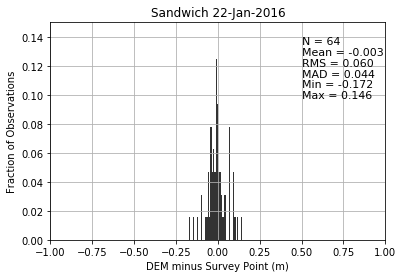

In [11]:
## Histogram of the data
x = df['DEMi_minus_trans'].as_matrix()
x = x[~np.isnan(x)]
x = x[np.abs(x)<5.]

xN = len(x)
xMAD = np.mean(np.abs(x))
xmean = x.mean()
xmin = x.min()
xmax = x.max()
xRMS = np.sqrt(np.mean(x**2))

fig = plt.figure()
# next line must be combined with normed=False to get fractional distribution correct
weights = np.ones_like(x)/float(len(x))
n, bins, patches = plt.hist(x, bins=40, weights=weights, normed=False, facecolor=(.2,.2,.2), alpha=1)
xaxmax = 1
xaxmin = -1
yaxmin = 0.
yaxmax = .15

plt.xlabel('DEM minus Survey Point (m)')
plt.ylabel('Fraction of Observations')
plt.title(ttext)
plt.axis([xaxmin, xaxmax, yaxmin, yaxmax])
plt.grid(True)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.9*(yaxmax-yaxmin)+yaxmin,'N = {}'.format(xN), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.85*(yaxmax-yaxmin)+yaxmin,'Mean = {:.3f}'.format(xmean), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.8*(yaxmax-yaxmin)+yaxmin,'RMS = {:.3f}'.format(xRMS), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.75*(yaxmax-yaxmin)+yaxmin,'MAD = {:.3f}'.format(xMAD), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.7 *(yaxmax-yaxmin)+yaxmin,'Min = {:.3f}'.format(xmin), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.65*(yaxmax-yaxmin)+yaxmin,'Max = {:.3f}'.format(xmax), fontsize=11)
plt.show()

fig_name = fdir+"hist_DEM_minus_transect.png"
fig.savefig(fig_name)

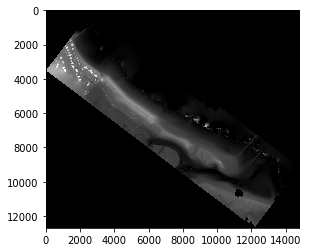

In [12]:
plt.plot(figsize=(12,6));plt.imshow(z[::],cmap=plt.cm.gray,vmin=-2,vmax=13)